In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import cv2
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from torchsummary import summary
from matplotlib import pyplot as plt
from torchvision import transforms
import numpy as np
from PIL import Image

In [ ]:
class ContrastiveLoss(torch.nn.Module):

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        pos = 25.0 * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        neg = 1.0 * torch.pow(euclidean_distance, 2)
        loss_contrastive = torch.mean((1 - label) * pos + label * neg)
        return loss_contrastive


In [ ]:
def get_pairs(dataset, batch_size):
    indices = np.random.choice(range(len(imglist)), size=int(len(imglist)/2), replace=False)

    original = []
    positive_counterparts = []
    negative_counterparts = []
    o_stack = []
    p_stack = []
    n_stack = []

    for index in indices:
        img = dataset[index]
        if len(o_stack) == batch_size or index == indices[-1]:
            original.append(torch.stack(o_stack, dim=0))
            o_stack = []
        o_stack.append(img[0])

        label = img[1] - 1
        choice = index

        while (label != img[1] and choice == index) or index == indices[-1]:
            choice = np.random.randint(0, len(dataset))
            label = dataset[choice][1]
        if len(p_stack) == batch_size:
            positive_counterparts.append(torch.stack(p_stack, dim=0))
            p_stack = []
        p_stack.append(dataset[choice][0])
        label = img[1]
        negative = index
        while label == img[1]:
            negative = np.random.randint(0, len(dataset))
            label = dataset[negative][1]
        if len(n_stack) == batch_size or index == indices[-1]:
            negative_counterparts.append(torch.stack(n_stack, dim=0))
            n_stack = []
        n_stack.append(dataset[negative][0])

    return (original, positive_counterparts, negative_counterparts)


def evaluate_pair(output1, output2, target, threshold):
    euclidean_distance = F.pairwise_distance(output1, output2)
    print(euclidean_distance)
    cond = euclidean_distance < threshold
    same_distances = []
    diff_distances = []



    same_sum = 0
    diff_sum = 0
    same_acc = 0
    diff_acc = 0

    for i in range(len(cond)):
        if target[i] == 0:
            same_sum += 1
            if cond[i]:
                same_acc += 1
                same_distances.append(euclidean_distance[i].item())
        elif target[i] == 1:
            diff_sum += 1
            if not cond[i]:
                diff_acc += 1
                diff_distances.append(euclidean_distance[i].item())

    print("Same pair distances:", same_distances[:10])
    print("Different pair distances:", diff_distances[:10])
    return same_acc, same_sum, diff_acc, diff_sum



def initialize_weights(m):
    classname = m.__class__.__name__

    if (classname.find('Linear') != -1):
        m.weight.data.normal_(mean = 0, std = 0.01)
    if (classname.find('Conv') != -1):
        m.weight.data.normal_(mean = 0.5, std = 0.01)


In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(50176, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 128),
        )

    def encode(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

    def forward(self, input1, input2):
        return self.encode(input1), self.encode(input2)


In [ ]:
face_proto = "./deploy.prototxt"  # Path to your prototxt file
face_model = "./res10_300x300_ssd_iter_140000.caffemodel"  # Path to your Caffe model
face_net = cv2.dnn.readNetFromCaffe(face_proto, face_model)

def detect_faces(image, conf_threshold=0.5):
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, scalefactor=1.0, size=(300, 300),
                                 mean=(104.0, 177.0, 123.0))
    face_net.setInput(blob)
    detections = face_net.forward()
    faces = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            startX, startY = max(0, startX), max(0, startY)
            endX, endY = min(w, endX), min(h, endY)
            face = image[startY:endY, startX:endX]
            faces.append(face)
    return faces

def detect_face_from_PIL(pil_image, conf_threshold=0.5):
    image_np = np.array(pil_image)
    image_cv = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

    faces = detect_faces(image_cv, conf_threshold=conf_threshold)
    if len(faces) > 0:
        face_cv = faces[0]
        face_rgb = cv2.cvtColor(face_cv, cv2.COLOR_BGR2RGB)
        return Image.fromarray(face_rgb)
    else:
        return pil_image


In [ ]:
class Contrast(torch.utils.data.Dataset):

    def __init__(self,atat_dataset):
        self.classes = atat_dataset.classes
        self.imgs = atat_dataset.imgs
        self.transform = atat_dataset.transform

    def __getitem__(self,index):
        self.target = np.random.randint(0,2)
        img1,label1 = self.imgs[index]
        new_imgs = list(set(self.imgs) - set(self.imgs[index]))
        length = len(new_imgs)
        # print(length)
        random = np.random.RandomState(42)
        if self.target == 1:
            label2 = label1
            while label2 == label1:
                choice = random.choice(length)
                img2,label2 = new_imgs[choice]
        else:
            label2 = label1 + 1
            while label2 != label1:
                choice = random.choice(length)
                img2,label2 = new_imgs[choice]

        img1 = Image.open(img1)
        img2 = Image.open(img2)

        img1 = detect_face_from_PIL(img1)
        img2 = detect_face_from_PIL(img2)

        img1 = img1.resize((224, 224))
        img2 = img2.resize((224, 224))

        img1 = img1.convert("L")
        img2 = img2.convert("L")

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return (img1,img2,self.target)

    def __len__(self):
        return(len(self.imgs))


In [ ]:

print("Torch is built with CUDA:", torch.cuda.is_available())

print("Available devices:")
for i in range(torch.cuda.device_count()):
    print(f"  {i}: {torch.cuda.get_device_name(i)}")

print("Current CUDA device:")
print(f"  ID: {torch.cuda.current_device()}")
print(f"  Name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

if torch.cuda.is_available():
    print("CUDA is available and enabled")
else:
    print("CUDA is not available or not enabled")

Torch is built with CUDA: True
Available devices:
  0: NVIDIA GeForce RTX 2060
Current CUDA device:
  ID: 0
  Name: NVIDIA GeForce RTX 2060
CUDA is available and enabled


In [ ]:
path = './gt_db'

bs = 64
lr = 1e-4
threshold = 0.35
margin = 2.5
epochs = 50


In [ ]:
model = SiameseNetwork()
model = model.cuda()
model.apply(initialize_weights)
optim = torch.optim.Adam(model.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optim,8)
criterion = ContrastiveLoss(margin)
#criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
train_transforms = torchvision.transforms.Compose([
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=(0.485),
                                             std=(0.229))
        ])
valid_transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
#             torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406),
#                                              std=(0.229, 0.224, 0.225))
        ])

test_transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
#             torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406),
#                                              std=(0.229, 0.224, 0.225))
        ])

train_ds = Contrast(ImageFolder(root = path + '/train',transform=train_transforms))
valid_ds = Contrast(ImageFolder(root = path + '/valid',transform=valid_transforms))
test_ds = Contrast(ImageFolder(root = path + '/test',transform=test_transforms))

train_dl = DataLoader(train_ds,batch_size=bs)
valid_dl = DataLoader(valid_ds,batch_size=bs)
test_dl = DataLoader(test_ds,batch_size=bs)

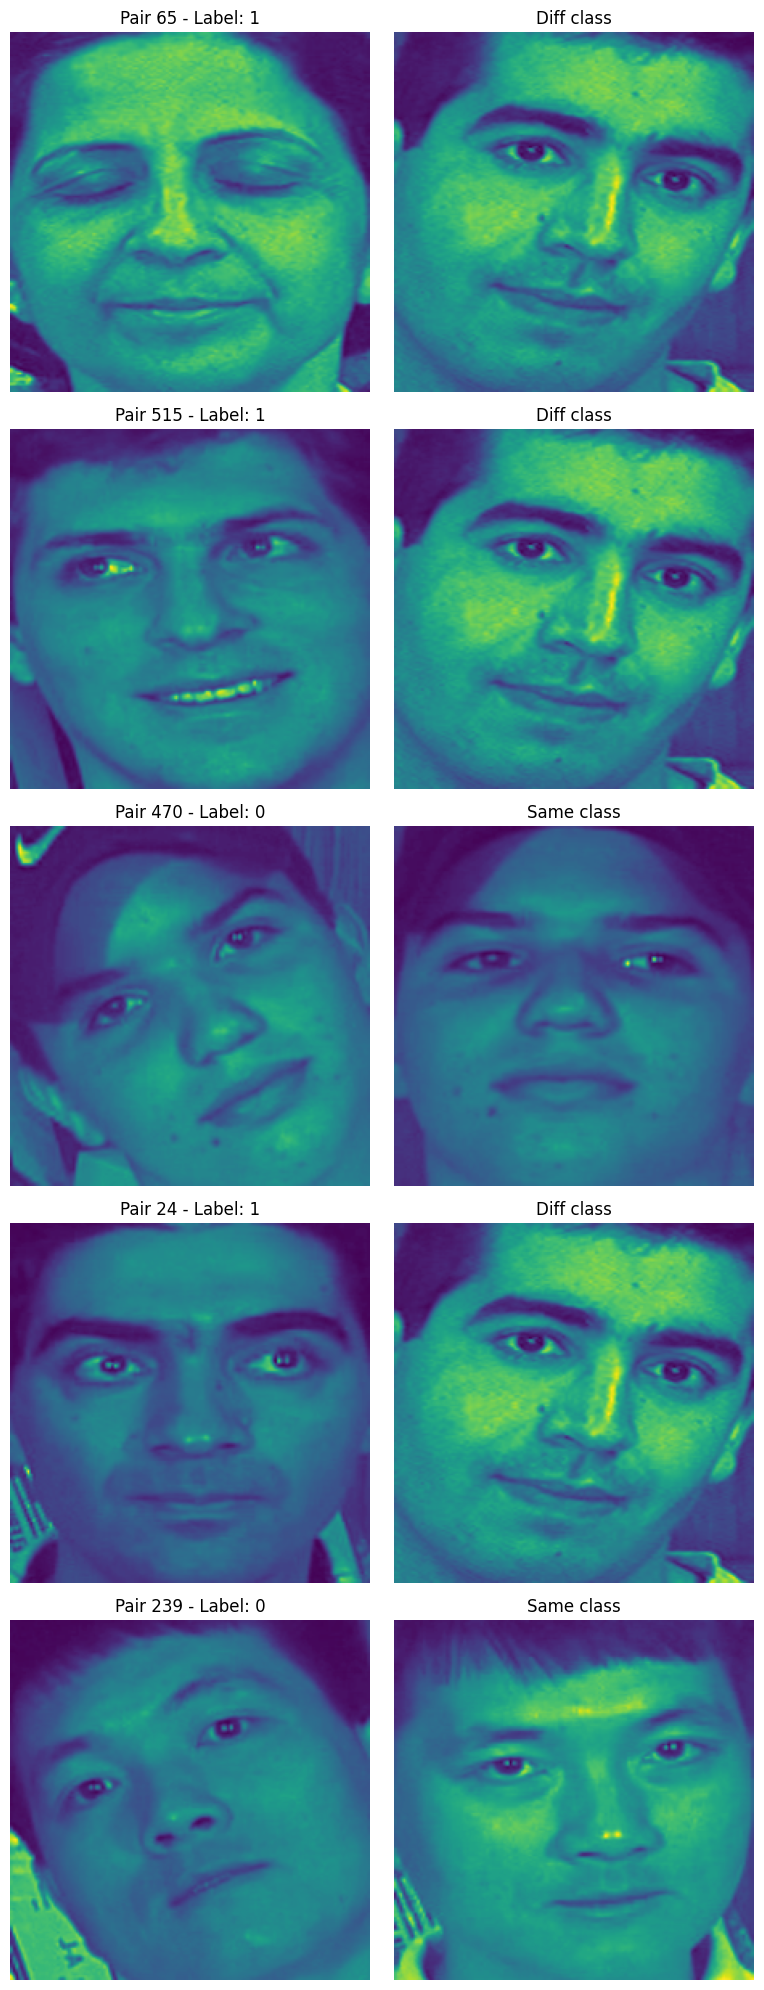

In [ ]:
import random
import matplotlib.pyplot as plt
import torch

MEAN = np.array([0.485])
STD  = np.array([0.229])

def unnormalize_image(tensor_img, mean, std):
    np_img = tensor_img.numpy().transpose((1, 2, 0))
    np_img = (np_img * std) + mean
    return np.clip(np_img, 0, 1)

def show_random_pairs_from_siamese_dataset(dataset, num_pairs=5, unnormalize=True):

    indices = random.sample(range(len(dataset)), num_pairs)
    fig, axes = plt.subplots(num_pairs, 2, figsize=(8, 4*num_pairs))

    for row, idx in enumerate(indices):
        img1, img2, label = dataset[idx]


        if isinstance(label, torch.Tensor):
            label = label.item()

        if unnormalize:
            np_img1 = unnormalize_image(img1, MEAN, STD)
            np_img2 = unnormalize_image(img2, MEAN, STD)
        else:

            np_img1 = img1.numpy().transpose((1,2,0))
            np_img2 = img2.numpy().transpose((1,2,0))

        axes[row, 0].imshow(np_img1)
        axes[row, 1].imshow(np_img2)

        axes[row, 0].set_title(f"Pair {idx} - Label: {label}")
        axes[row, 1].set_title("Same class" if label == 0 else "Diff class")

        axes[row, 0].axis('off')
        axes[row, 1].axis('off')

    plt.tight_layout()
    plt.show()

show_random_pairs_from_siamese_dataset(train_ds, num_pairs=5, unnormalize=True)


Trenovanie

In [ ]:
summary(model,[(1,224,224),(1,224,224)],batch_size = bs)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 32, 224, 224]             320
       BatchNorm2d-2         [64, 32, 224, 224]              64
              ReLU-3         [64, 32, 224, 224]               0
         MaxPool2d-4         [64, 32, 112, 112]               0
            Conv2d-5         [64, 64, 112, 112]          18,496
       BatchNorm2d-6         [64, 64, 112, 112]             128
              ReLU-7         [64, 64, 112, 112]               0
         MaxPool2d-8           [64, 64, 56, 56]               0
            Conv2d-9           [64, 64, 56, 56]          36,928
      BatchNorm2d-10           [64, 64, 56, 56]             128
             ReLU-11           [64, 64, 56, 56]               0
        MaxPool2d-12           [64, 64, 28, 28]               0
           Linear-13                 [64, 4096]     205,524,992
             ReLU-14                 [6

C:\Users\brano\AppData\Local\Programs\Python\Python310\lib\site-packages\torchsummary\torchsummary.py:100: RuntimeWarning: overflow encountered in scalar multiply
  total_input_size = abs(np.prod(input_size) * batch_size * 4. / (1024 ** 2.))


In [ ]:
from torchviz import make_dot

# Dummy dáta - dva obrázky
input1 = torch.randn(1, 1, 224, 224).cuda()
input2 = torch.randn(1, 1, 224, 224).cuda()

# Prejdi modelom
output = model(input1, input2)

# Vykresli graf
dot = make_dot(output, params=dict(model.named_parameters()))
dot.render("siamese_model_graph", format="png")  # Vygeneruje siamese_model_graph.png


'siamese_model_graph.png'

In [ ]:
import os

train_loss = []
valid_loss = []
best_val_loss = float('inf')
best_epoch = -1

for epoch in range(epochs):
    train_epoch_loss = 0
    model.train()

    for i,(input1,input2,target) in enumerate(train_dl):
        optim.zero_grad()
        output1,output2 = model(input1.cuda(),input2.cuda())
        out = model(input1.cuda(),input2.cuda())

        loss = criterion(output1,output2,target.cuda())
        train_epoch_loss += loss.item()
        loss.backward()
        optim.step()

    train_epoch_loss /= len(train_ds)
    train_loss.append(train_epoch_loss)

    print("Epoch [{}/{}] ----> Training loss :{} \n".format(epoch+1,epochs,train_epoch_loss))

    valid_epoch_loss = 0
    val_pos_accuracy = 0
    val_neg_accuracy = 0
    num_pos = 0
    num_neg = 0
    model.eval()

    for i,(input1,input2,target) in enumerate(valid_dl):
        output1,output2 = model(input1.cuda(),input2.cuda())
        loss = criterion(output1,output2,target.cuda())
        valid_epoch_loss += loss.item()
        pos_acc,pos_sum,neg_acc,neg_sum = evaluate_pair(output1,output2,target.cuda(),threshold)
        val_pos_accuracy+=pos_acc
        val_neg_accuracy+=neg_acc
        num_pos+=pos_sum
        num_neg+=neg_sum

    valid_epoch_loss /= len(valid_ds)
    val_pos_accuracy /= num_pos
    val_neg_accuracy /= num_neg

    valid_loss.append(valid_epoch_loss)

    subfolder = "checkpoints"
    os.makedirs(subfolder, exist_ok=True)
    checkpoint_filename = os.path.join(subfolder, f"model_PAcc{val_pos_accuracy:.4f}_NAcc{val_neg_accuracy:.4f}.pth")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optim.state_dict(),
        'val_loss': valid_epoch_loss,
        'P_acc': val_pos_accuracy,
        'N_acc': val_neg_accuracy,
    }, checkpoint_filename)


    print("Validation loss :{} \t\t\t P Acc : {}, N Acc: {}\n".format(valid_epoch_loss,val_pos_accuracy,val_neg_accuracy))



In [ ]:
plt.figure(figsize = (10,5))
plt.plot(train_loss,label = 'train')
plt.plot(valid_loss,label = 'valid')
plt.xlabel("Epochs",size = 20)
plt.ylabel("Loss", size = 20)
plt.ylim(0,2)
plt.legend()
plt.show()

In [ ]:
checkpoint = torch.load('./checkpoints/model_PAcc0.6471_NAcc0.9756.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optim.load_state_dict(checkpoint['optimizer_state_dict'])
best_epoch = checkpoint['epoch']
best_val_loss = checkpoint['val_loss']

print(f"Loaded best model from epoch {best_epoch} with validation loss: {best_val_loss}")
model.eval()


C:\Users\brano\AppData\Local\Temp\ipykernel_4548\3884780503.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./checkpoints/model_PAcc0.6471_NAcc0

Loaded best model from epoch 28 with validation loss: 1.3783157348632813


SiameseNetwork(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=50176, out_features=4096, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (

In [ ]:
def show(img, ax, d):
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')

    if d[0] < 0.3:
        title = f"YES (Dissimilarity: {d[0]:.4f})"
    else:
        title = f"NO (Dissimilarity: {d[0]:.4f})"

    ax.set_title(title, fontweight="bold", size=24)
    ax.set_xticks([])
    ax.set_yticks([])


In [ ]:
all_transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),])
all_ds = Contrast(ImageFolder(root = path + '/valid',transform=train_transforms))

In [ ]:
print(all_ds.classes)

['Branislav_Hetnerovic', 'viera lukacova']


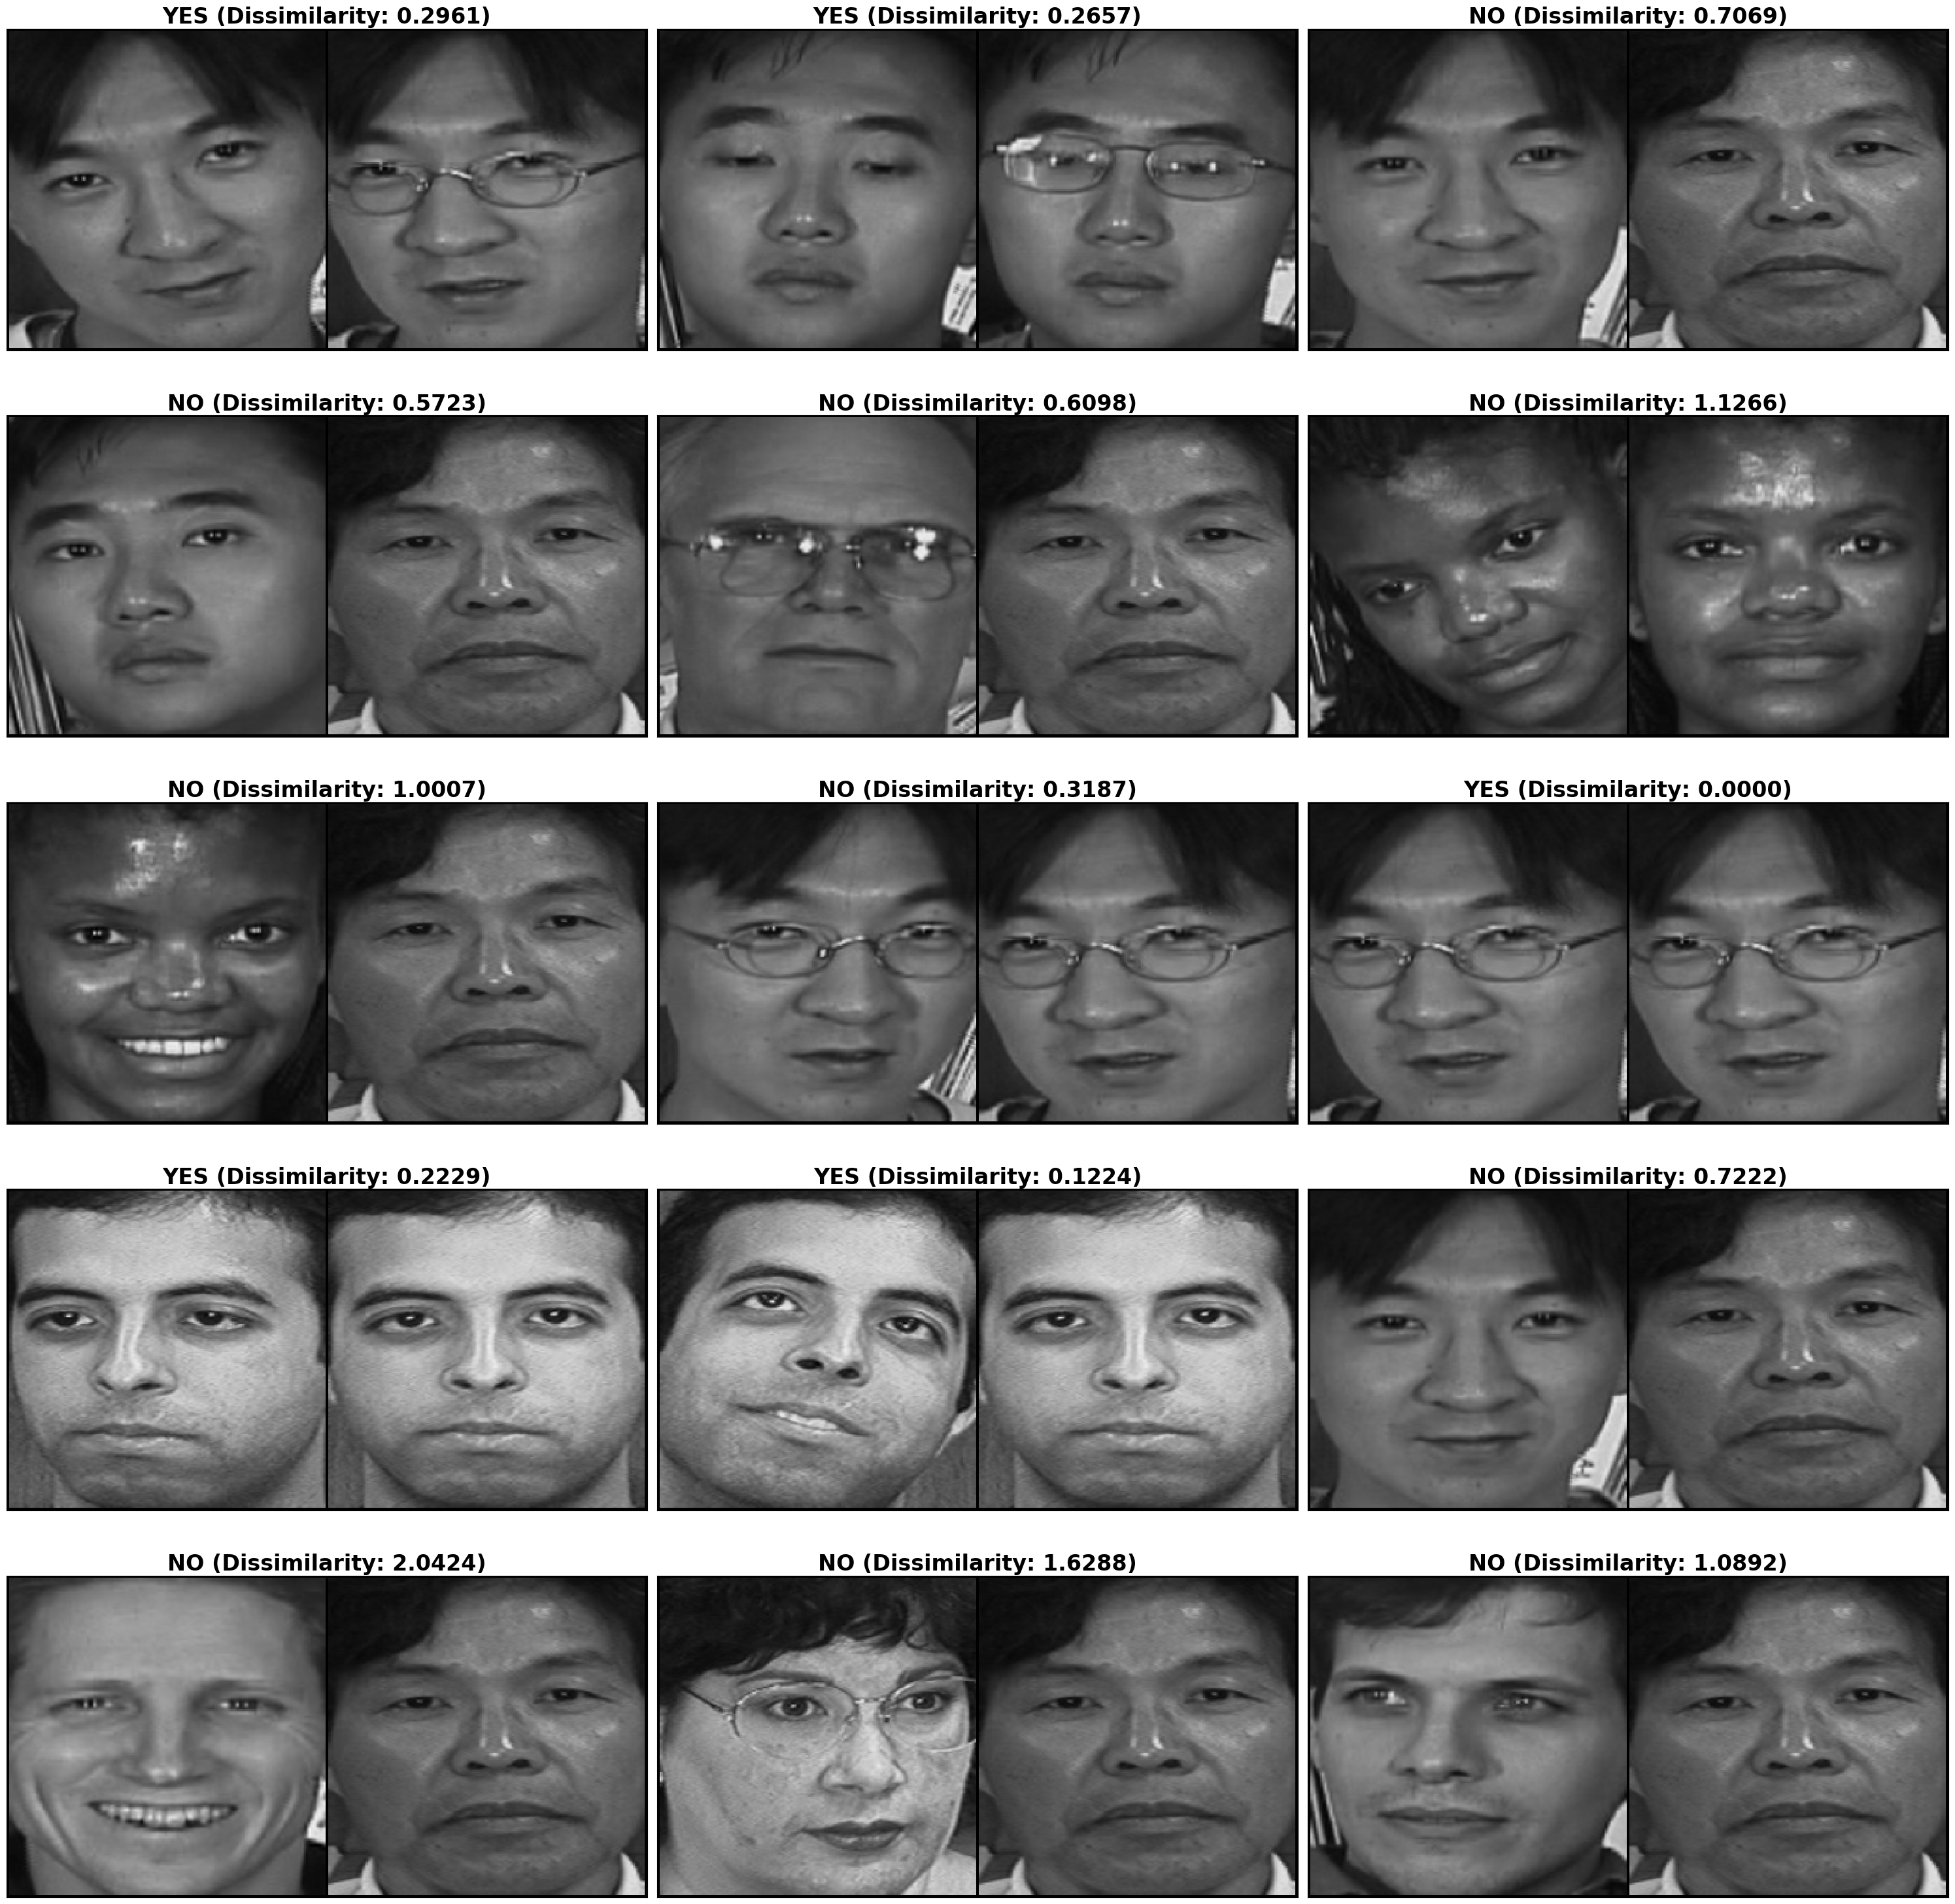

In [ ]:
fig, axes = plt.subplots(5, 3, figsize=(30, 30))
axes = axes.flatten()
for i in range(15):
    idx = np.random.randint(0, len(test_ds))
    input1, input2, target = test_ds[idx]
    output1, output2 = model(input1.unsqueeze(0).cuda(), input2.unsqueeze(0).cuda())
    grid = torchvision.utils.make_grid([input1, input2])
    euclidean_distance = F.pairwise_distance(output1, output2)
    show(grid, axes[i], euclidean_distance.cpu().detach().numpy())
plt.tight_layout()
plt.show()




In [ ]:
import xiapi
import cv2
import os
import time

your_name = 'aaaaa'
base_dir = './gt_db/valid'
save_path = os.path.join(base_dir, your_name)
os.makedirs(save_path, exist_ok=True)

cam = xiapi.Camera()
print("Opening camera...")
cam.open_device()
cam.set_exposure(8000)
cam.start_acquisition()
img = xiapi.Image()

cv2.namedWindow('Full Image Capture', cv2.WINDOW_NORMAL)
cv2.resizeWindow('Full Image Capture', 640, 480)

print("Capturing 15 full-frame images. Press 'q' to cancel.")
count = 0
while count < 15:
    cam.get_image(img)
    frame = img.get_image_data_numpy()

    resized = cv2.resize(frame, (640, 480))
    cv2.imshow('Full Image Capture', resized)

    filename = os.path.join(save_path, f'{your_name}_{count+1:02d}.jpg')
    cv2.imwrite(filename, frame)
    print(f"Saved: {filename}")
    count += 1
    time.sleep(0.3)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        print("Capture cancelled.")
        break

cam.stop_acquisition()
cam.close_device()
cv2.destroyAllWindows()
print("Done.")
